# Exercise 2
In this exercise you will explore how hard it is to find the best balance between TPR and FPR. 

We will then turn to applying multi-class classifiers over the well known MNIST digits database, and analyse the results using a confusion matrix.

## Balancing TPR and FPR and interpretability of a classifier results given imbalance between classes
After your yearly checkup, the doctor has bad news and good news. The bad news is that you tested positive for a serious disease, and that the test is 99% accurate (i.e. the probability of testing positive given that you have the disease is 0.99, as is the probability of testing negative given that you don’t have the disease). The good news is that this is a rare disease, striking only 1 in 10,000 people. 

### Questions:
##### 1. What are the TPR and FPR of the chosen classifier in this case? 

***We were given:***
<br>P(healthy) = 0.9999
<br>P(ill) = 0.0001
<br>P(positive test | healthy) = 0.99
<br>P(positive test | ill)  = 0.01

<br>True positive rate (TPR), Recall, Sensitivity, probability of detection, 
<br>Power = Σ True positive / Σ Condition positive and can be calculated as
<br>TPR = (TP / (TP + FP))

<br> False positive rate (FPR), Fall-out is also known as 
<br>Probability of false alarm = Σ False positive / Σ Condition negative and can be calculated as 
<br>FPR =(FP / (FP + TN)) = (1 − TPR)

***Calculating:***

In [1]:
TPR = round(0.99/(0.99+0.9999*0.01), 4)
print(f'TPR is: {TPR}')

TPR is: 0.99


In [2]:
FPR = round(1 - TPR,4)
print(f'FPR is: {FPR}')

FPR is: 0.01


##### Giving that there is a balance between the two --- is it a good point on the ROC curve? 



The closer an ROC curve is to the upper left corner, the more efficient is the test. <br>So, yes, our point will be definitely a good point on the ROC curve <br>We defined  almost perfect point:
minimum false positive errors and  maximum true positives

***2. Why is it good news that the disease is rare?***

Because we got the small chance to be infected with that disease and high accuracy predictive test 
<br> and even if you will be infected, there is a very little chances that the test

***What are the chances that you actually have the disease?***


The chances that you actually have the disease we able to calculate by using Baise theorem here:

<br>P(ill | positive test) =  P(positive | ill) * P(ill)/P(positive test) + P(negative test| ill) * P(ill) / P(negative) 

In [3]:
chances = 0.99*0.0001 / (0.99*0.0001 +0.01*0.9999)
print(f'The chances that you actually have the disease are: {round(chances,4)},\ni.e. {round(chances*100,2)}% out of those who are diagnosed disease')

The chances that you actually have the disease are: 0.0098,
i.e. 0.98% out of those who are diagnosed disease



***3. Taking into account the previous answers, would you say the designer of the classifier made a good choice in this case?***

Yes, In a good classifier we can achieve high TPR at low FPR (at optimal threshold)

## Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model) and Multivariate Logistic Regression (a discriminative model). 

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathematical analysis clarity, and for matching expected API, each image flattens to create a 1D array with 784 elements.

In [4]:
import pandas as pd
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
%matplotlib inline
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


## Loading the MNIST dataset
### Question 4:       
<br> **Load the MNIST data set. Use**
>```mnist = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)```

to fetch the original data from the openml.org repository of open datasets for machine learning. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

---
**Note:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the performance of the algorithms below on the preprocessed data as well.



In [5]:
mnist = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

Let's split the data for more convenient use

In [6]:
X = mnist[0]
y = mnist[1]
mnist[0].shape

(70000, 784)

We got the needed shape, now we can take some unique values to plot them

In [7]:
nums = np.unique(X)
nums10 = nums[:10]

In [8]:
nums10

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

#### Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

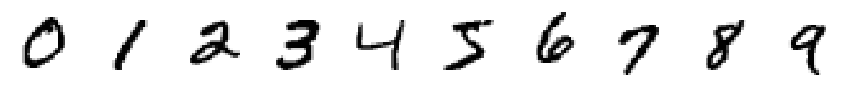

In [9]:
fig = plt.figure(figsize = (15,15))
for i in nums10:
    fig.add_subplot(1,len(nums10), i+1)
    index =  np.flatnonzero(y.astype(int) == i)[0]
    some_digit = X[index].reshape(28, 28)
    plt.imshow(some_digit, cmap=matplotlib.cm.binary)
    plt.axis('off');


#### Finally, divide your data into train and test sets, using 1/7 of the data for testing.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

Let's check the shape of splitting sets in %

In [11]:
print(f"Train set size:'{round(len(X_train)/len(y)*100,2)}%\nTest set size:{round(len(X_test)/len(y)*100,2)}%")

Train set size:'85.71%
Test set size:14.29%


# Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixel is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$

### Question 5:
<br><b>Write the classification rule based on this Naive Bayes model. </b>

Every pair of features being classified is independent of each other.
<br>goal: to compute the posterior distribution 
<br>$ P_{ji}(x) = Pr(y|x_{i})$ = $\hat{j}$ = $argmax_{c} P(y|x_{i})$ = $argmax P(y)*ПP(x_{i}|y)$, $i\in 0\ldots 784$



#### How would you estimate each of the parameters of the model based on the training data? 

The conditional independence is a strong assumption (that’s the “naive” part),
however, in many cases simplicity is just what we need:
<br>We prefer simple models if they are accurate enough
<br>During training we need to estimate the likelihood functions and priors of each
class. 
<br>After that all we need to do is to put in use the Bayes rule, with the independence assumption, and find the MAP.
<br>It’s a simple matter of calculating a bunch of figures, and finding which class gave
the maximal result.



### Bonus:
<br> <b> Think of edge cases which may effect your estimator in an undesired way.</b>

The model can
include any (finite) number of classes you wish to have --- you still just need to
choose “argmax” over all possible classes.

### Question 6a:
**Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).**

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

In [12]:
nb = BernoulliNB()
nb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [13]:
y_bern = nb.predict(X_test)


### Question 6b: 
#### Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attibute of the trained model.


Let's Plot the mean image of each class

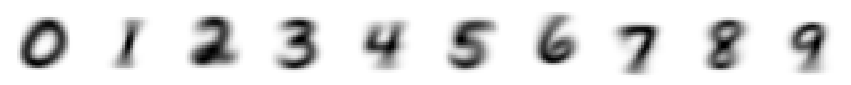

In [14]:
fig = plt.figure(figsize = (15,15))
for i in range(len(nums10)):
    idxs = np.flatnonzero(y_train.astype(int) == i)
    X_mean = X_train[idxs].mean(axis = 0)
    some_digit = X_mean.reshape(28, 28)
    plt.subplot(1, len(nums10), i + 1)
    plt.imshow(some_digit, cmap=matplotlib.cm.binary)
    plt.axis('off');

And generate one sample of each class of the trained model

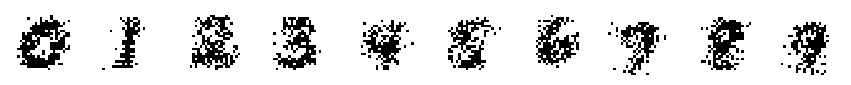

In [43]:
# get the log probabilities
log_probs = np.exp(nb.feature_log_prob_) 
some_digit = pd.DataFrame(log_probs) 
for i in range(log_probs.shape[1]):
    for dig in range(log_probs.shape[0]):
        some_digit.iloc[dig,i] = np.random.binomial(n=1,p=some_digit.iloc[dig,i]) 

        
# plot random images
plt.figure(figsize=(15,15))
for i in range(log_probs.shape[0]):
    plt.subplot(1,log_probs.shape[0],i+1)
    plt.imshow(some_digit.iloc[i].values.reshape(28, 28),cmap=matplotlib.cm.binary)
    plt.axis('off');



### Question 6c:
#### Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.


In [17]:
cm = confusion_matrix(y_test, y_bern)
cm

array([[ 881,    0,    6,   12,    1,   39,   21,    1,   20,    2],
       [   0, 1110,    6,    6,    0,   12,    3,    0,   12,    3],
       [  13,   16,  805,   26,   17,    6,   41,    5,   36,    2],
       [   5,   30,   49,  830,    2,   23,    8,   14,   45,   28],
       [   2,    7,    6,    0,  724,    6,   16,    5,   18,  122],
       [  20,   17,    7,  139,   24,  680,   20,    3,   13,   14],
       [  12,   33,   21,    1,   13,   25,  855,    0,    1,    0],
       [   5,   22,    8,    2,   27,    3,    0,  890,   19,   79],
       [  16,   39,   19,   80,   10,   33,    5,    5,  720,   42],
       [   6,   21,    4,    9,   77,    4,    0,   33,   29,  853]])

In [18]:
def draw_confusionmatrix(ytest, yhat):
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(ytest, yhat)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 13},fmt="d", cmap=plt.cm.cividis)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix of classifier')

    acc = accuracy_score(ytest, yhat)
    print(f"Sum Axis-1 as Total Accuracy(fraction of correctly classified images): {acc}")

Sum Axis-1 as Total Accuracy(fraction of correctly classified images): 0.8348


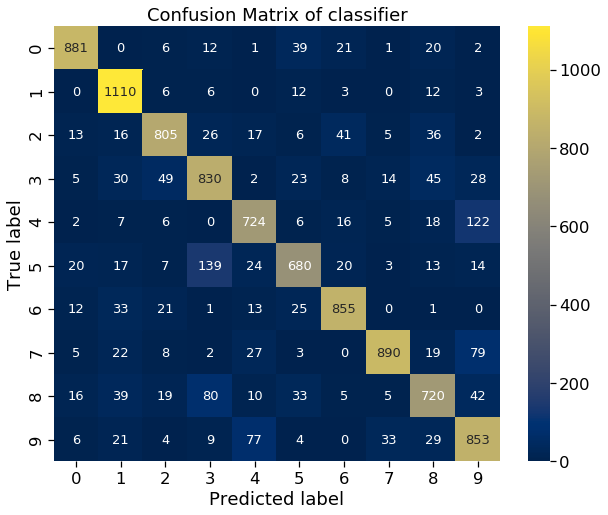

In [19]:
draw_confusionmatrix(y_test, y_bern)

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier
<br>The fraction of correctly classified images is 0.8348 - it's not so good as could be, i.e. the prediction will be correct only in 83,48% cases

### Question 6d:
#### Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**

Converting a greyscale image to monochrome is a common image processing task. `Otsu's method`, named after its inventor Nobuyuki Otsu, is one of many binarization algorithms

Otsu's thresholding method involves iterating through all the possible threshold values and calculating a measure of spread for the pixel levels each side of the threshold, i.e. the pixels that either fall in foreground or background. The aim is to find the threshold value where the sum of foreground and background spreads is at its minimum.

Also, we can calculate what is called the `between class variance`, which is far quicker to calculate. Luckily, the threshold with the maximum between class variance also has the minimum within class variance. So it can also be used for finding the best threshold and therefore due to being simpler is a much better approach to use.

### Multivariate Logistic Regression
We will now look at a discriminative model for this problem, specifically, the Multivariate Logistic Regression model. Again, we will use a prepared implementation of the model, so you won't need to implement it.

In this part we will keep the pixel values in grayscale, and assume the probability of each image being classified as one of the 10 digit classes, matches some multivariate logistic function.

### Question 7a:
#### Run a Multivariate Logitic Regression classifier on the training data and apply predictions on the test data. Use the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation, and set the `solver` to be `'lbfgs'`.

Note that here we cannot "generate" examples from the model, nor plot the "mean image".

In [20]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/home/gal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
y_log_reg=logreg.predict(X_test)


### Question 7b:
#### As we did for the Naive Bayes classifier above, plot the confusion matrix of your classifier, as calculated on the test data, and calculate the total accuracy. Summarize the results in your own words.


In [22]:
cm = confusion_matrix(y_test, y_log_reg)
cm

array([[ 941,    0,    5,    1,    3,   10,   11,    4,    7,    1],
       [   0, 1123,    4,    6,    1,    5,    0,    2,    9,    2],
       [   3,   15,  865,   20,   10,    4,   17,    8,   22,    3],
       [   2,    5,   27,  937,    1,   25,    2,   10,   13,   12],
       [   3,    1,    4,    6,  837,    4,   11,    3,    7,   30],
       [   6,    9,    5,   43,    8,  797,   17,    1,   41,   10],
       [   7,    3,   12,    0,   11,   10,  914,    1,    3,    0],
       [   3,    2,   23,    4,    8,    3,    0,  987,    1,   24],
       [   8,   13,   13,   31,    5,   26,    9,    8,  843,   13],
       [   5,    7,    3,   12,   23,    6,    0,   26,    9,  945]])

Sum Axis-1 as Total Accuracy(fraction of correctly classified images): 0.9189


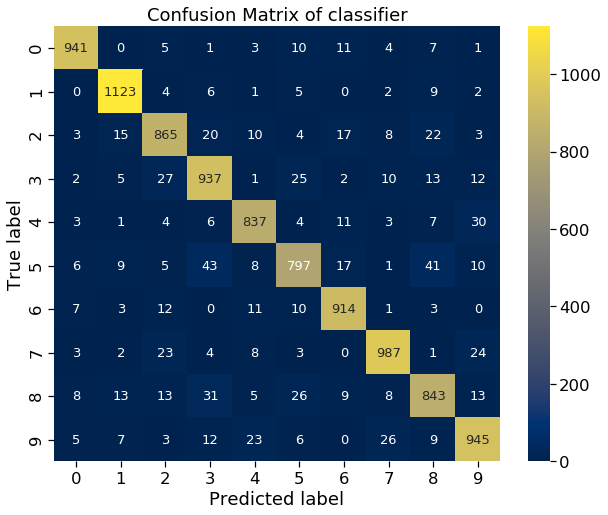

In [23]:
draw_confusionmatrix(y_test, y_log_reg)

The fraction of correctly classified images is 0.9189, i.e. the prediction will be correct in 91,89% cases - it's much better than it was, when we where using naive_bayes.BernoulliNB implementation to classify images


### Question 7c:
#### Show some test images which were misclassified (classified incorrectly). Choose one such sample, and output the probability estimates for all classes (use the `predict_proba` function). Describe the results.


In [24]:
error = X_test[y_test != y_log_reg]
true = y_test[y_test != y_log_reg]
pred = y_log_reg[y_test != y_log_reg]

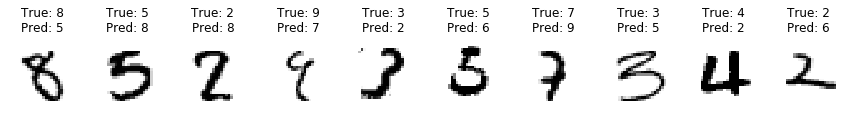

In [25]:
plt.figure(figsize=(15,15))
for i in range(len(nums10)):
    some_digit = error[i].reshape(28, 28)
    plt.subplot(1, 10, i + 1)
    plt.imshow(some_digit, cmap=matplotlib.cm.binary)
    plt.axis('off')  
    plt.title(f"True: {true[i]}\nPred: {pred[i]}",fontsize=12)

Here we see the errors and wrong predicted pictures, we could se that on the plot with confusing matrix(mixed up 5x3, 2x8, 9x7 etc.) but in genearl, our model works well

Let's take the first one numner from the set and will check the probabilities

In [27]:
pd.DataFrame(np.round(logreg.predict_proba(error),2)).iloc[0].max()

0.54

In [28]:
pd.DataFrame(np.round(logreg.predict_proba(error),2)).iloc[0]

0    0.00
1    0.00
2    0.00
3    0.00
4    0.00
5    0.54
6    0.01
7    0.00
8    0.45
9    0.00
Name: 0, dtype: float64

In [29]:
pred[0]

'5'

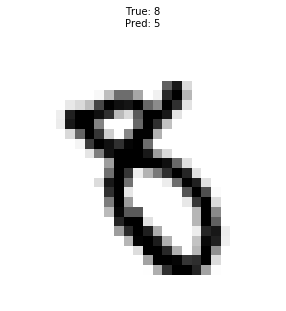

In [30]:
plt.figure(figsize=(5,5))
some_digit = error[0].reshape(28, 28)
plt.imshow(some_digit, cmap=matplotlib.cm.binary)
plt.title(f"True: {true[0]}\nPred: {pred[7]}",fontsize=10)
plt.axis('off');

Some randomly taken numbers and theirs predictions:

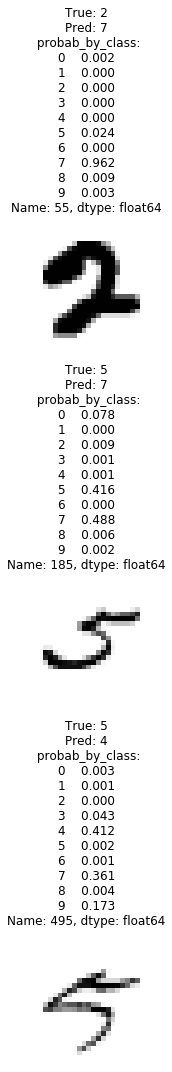

In [45]:
plt.figure(figsize=(15,15))
for i in range(3):
    some_num = random.randint(1,len(error))
    some_digit = error[some_num].reshape(28, 28)
    plt.subplot(3,1, i + 1)
    plt.imshow(some_digit, cmap=matplotlib.cm.binary)
    plt.axis('off')  
    plt.tight_layout()
    plt.title(f"True: {true[some_num]}\nPred: {pred[some_num]}\n probab_by_class:\n{pd.DataFrame(np.round(logreg.predict_proba(error),3)).iloc[some_num]}",fontsize=12)
  